# Домашнее задание: LARS и варианты реализации многоклассовой классификации

## Задание 1: Реализация регрессии с наименьшими углами (LARS)
Регрессия с наименьшими углами (LARS) — это алгоритм регрессии, который выбирает признаки пошагово, что делает его подходящим для задач с большим количеством признаков. Цель — найти подмножество признаков, которые наилучшим образом объясняют целевую переменную.

- LARS начинается с нуля для всех коэффициентов.

- Алгоритм находит признак, наиболее коррелирующий с откликом, и обновляет коэффициент этого признака до его значения по методу наименьших квадратов, пока не будут включены все признаки или не выполнено условие остановки.

Тут можно прочитать подробнее про алгоритм работы https://www.geeksforgeeks.org/least-angle-regression-lars/

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.linear_model import Lars


class LARS:
    def __init__(self, n_nonzero_coefs=500, fit_intercept=True, normalize=True, eps=1e-12):
        self.n_nonzero_coefs = n_nonzero_coefs
        self.fit_intercept = fit_intercept
        self.normalize = normalize
        self.eps = eps

    def fit(self, X, y):
      X = X.copy().astype(np.float64)
      y = y.copy().astype(np.float64)
      n_samples, n_features = X.shape

      if self.fit_intercept:
          self.X_mean_ = X.mean(axis=0)
          self.y_mean_ = y.mean()
          X -= self.X_mean_
          y -= self.y_mean_
      else:
          self.X_mean_ = np.zeros(X.shape[1])
          self.y_mean_ = 0.

      if self.normalize:
          self.X_std_ = np.linalg.norm(X, axis=0)
          self.X_std_[self.X_std_ == 0] = 1.0
          X /= self.X_std_
      else:
          self.X_std_ = np.ones(X.shape[1])

      self.coef_ = np.zeros(n_features)
      self.active_ = []
      self.inactive_ = list(range(n_features))
      self.alphas_ = []
      self.coef_path_ = []

      mu = np.zeros(n_samples)
      Gram = X.T @ X

      for step in range(min(self.n_nonzero_coefs, n_features)):
          c = X.T @ (y - mu)
          C = np.max(np.abs(c))

          if C < self.eps:
              break

          j = np.argmax(np.abs(c))
          if j not in self.active_:
              self.active_.append(j)
              self.inactive_.remove(j)

          A = np.array(self.active_)
          s = np.sign(c[A])

          G = Gram[np.ix_(A, A)]

          G_inv = np.linalg.inv(G)
          ones = np.ones(len(A))
          A_vec = G_inv @ s
          A_val = 1 / np.sqrt(np.sum(s * A_vec))
          w = A_val * A_vec
          u = X[:, A] @ w

          a = X.T @ u

          gamma_candidates = []
          for k in self.inactive_:
              gamma_plus = (C - c[k]) / (A_val - a[k]) if A_val != a[k] else np.inf
              gamma_minus = (C + c[k]) / (A_val + a[k]) if A_val != -a[k] else np.inf
              gamma_candidates.extend([gamma_plus, gamma_minus])

          gamma = min([g for g in gamma_candidates if g > self.eps], default=C / A_val)

          mu += gamma * u

          self.coef_[A] += gamma * w
          self.coef_path_.append(self.coef_.copy())
          self.alphas_.append(C)

      self.coef_path_ = np.array(self.coef_path_).T

      return self

    def predict(self, X):
        X = X.copy().astype(np.float64)
        if self.fit_intercept:
            X -= self.X_mean_
        if self.normalize:
            X /= self.X_std_
        return X @ self.coef_ + self.y_mean_




X_train = np.array([[1], [2], [3], [4], [5]])
y_train = np.array([2, 3, 5, 7, 11])
model = LARS()
model.fit(X_train, y_train)
preds = model.predict(X_train)

In [58]:
# Проверки для проверки предсказаний
assert preds.shape == (5,)
assert r2_score(y_train, preds) > 0.8

In [59]:
# Сравнение с реализацией из sklearn
sklearn_model = Lars()
sklearn_model.fit(X_train, y_train)
sklearn_preds = sklearn_model.predict(X_train)
assert np.allclose(preds, sklearn_preds, rtol=1e-03)


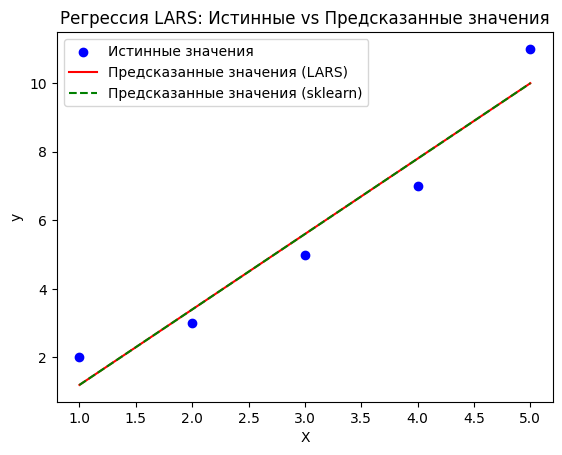

In [60]:
plt.scatter(X_train, y_train, color='blue', label="Истинные значения")
plt.plot(X_train, preds, color='red', label="Предсказанные значения (LARS)")
plt.plot(X_train, sklearn_preds, color='green', linestyle='dashed', label="Предсказанные значения (sklearn)")
plt.legend()
plt.title("Регрессия LARS: Истинные vs Предсказанные значения")
plt.xlabel("X")
plt.ylabel("y")
plt.show()

## Задание 2: Классификация Один-против-Всех и Все-против-Всех с логистической регрессией
В многоклассовой классификации два популярных подхода:

- Один-против-Всех (OvA): Для каждого класса обучается отдельный классификатор, который отделяет этот класс от всех остальных.
- Все-против-Всех (AvA): Обучается классификатор для каждой пары классов.

https://education.yandex.ru/handbook/ml/article/linear-models#:~:text=%D0%9C%D0%BD%D0%BE%D0%B3%D0%BE%D0%BA%D0%BB%D0%B0%D1%81%D1%81%D0%BE%D0%B2%D0%B0%D1%8F%20%D0%BA%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%86%D0%B8%D1%8F-,%D0%9C%D0%BD%D0%BE%D0%B3%D0%BE%D0%BA%D0%BB%D0%B0%D1%81%D1%81%D0%BE%D0%B2%D0%B0%D1%8F%20%D0%BA%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%86%D0%B8%D1%8F,-%D0%92%20%D1%8D%D1%82%D0%BE%D0%BC%20%D1%80%D0%B0%D0%B7%D0%B4%D0%B5%D0%BB%D0%B5

In [61]:
def plot_ova_classifier(classifier, X, y):
    plt.figure(figsize=(10, 6))
    colors = ['blue', 'green', 'red']
    for i in np.unique(y):
        plt.scatter(X[y == i][:, 0], X[y == i][:, 1], color=colors[i], label=f"Класс {i}")

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    # Z_probabilities = classifier.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    # Z = np.max(Z_probabilities, axis=1).reshape(xx.shape)

    Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.7, cmap='coolwarm')

    # plt.scatter(X[:, 0], X[:, 1], color='black')
    plt.title("One-vs-All")
    plt.xlabel("Признак 1")
    plt.ylabel("Признак 2")
    # plt.colorbar(label="Вероятность")
    plt.legend()
    plt.show()


def plot_ava_classifier(classifier, X, y):
    plt.figure(figsize=(10, 6))
    colors = ['blue', 'green', 'red']
    for i in np.unique(y):
        plt.scatter(X[y == i][:, 0], X[y == i][:, 1], color=colors[i], label=f"Класс {i}")

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    # Z_probabilities = classifier.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    # Z = np.max(Z_probabilities, axis=1).reshape(xx.shape)
    Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.7, cmap='coolwarm')

    # plt.scatter(X[:, 0], X[:, 1], color='black')
    plt.title("All-vs-All")
    plt.xlabel("Признак 1")
    plt.ylabel("Признак 2")
    # plt.colorbar(label="Вероятность")
    plt.legend()
    plt.show()

In [62]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from itertools import combinations

class OneVsAllClassifier:
    def __init__(self):
        self.models = []
        self.classes_ = None

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        self.models = []

        for class_label in self.classes_:
            binary_y = np.where(y == class_label, 1, 0)

            model = LogisticRegression()
            model.fit(X, binary_y)
            self.models.append(model)

    def predict(self, X):
        scores = np.array([model.decision_function(X) for model in self.models]).T
        return self.classes_[np.argmax(scores, axis=1)]


X_test = np.array([[1, 2], [4, 5], [7, 8], [2, 3], [5, 6]])
y_test = np.array([0, 1, 2, 0, 1])
ova_classifier = OneVsAllClassifier()
ova_classifier.fit(X_test, y_test)
ova_preds = ova_classifier.predict(X_test)

assert len(ova_preds) == len(X_test), "Предсказания должны соответствовать количеству образцов"
assert accuracy_score(y_test, ova_preds) > 0.8, "Точность должна быть выше 0.8"

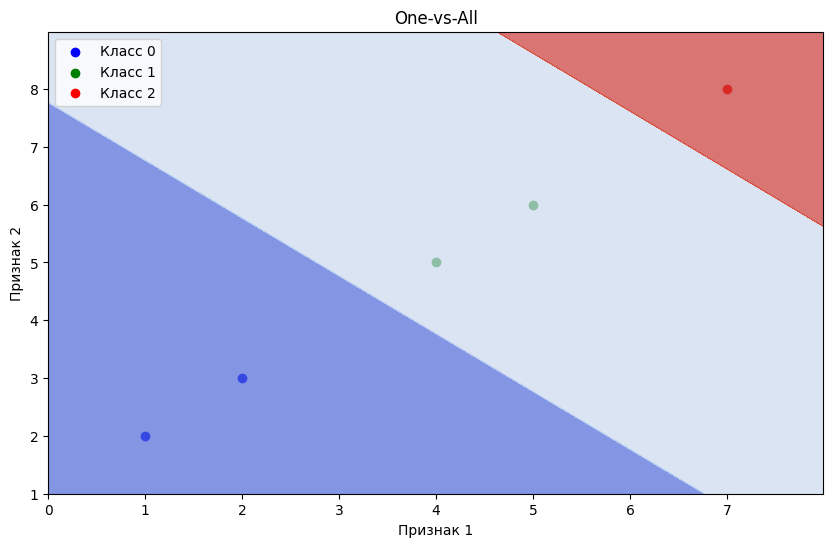

In [63]:
plot_ova_classifier(ova_classifier, X_test, y_test)

In [64]:

class AllVsAllClassifier:
    def __init__(self):
        self.pairwise_models = {}
        self.classes_ = None

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        self.pairwise_models = {}
        for class1, class2 in combinations(self.classes_, 2):
            mask = np.logical_or(y == class1, y == class2)
            X_pair = X[mask]
            y_pair = y[mask]

            binary_y = np.where(y_pair == class1, 0, 1)

            model = LogisticRegression()
            model.fit(X_pair, binary_y)
            self.pairwise_models[(class1, class2)] = model

    def predict(self, X):
        votes = np.zeros((X.shape[0], len(self.classes_)))

        for (class1, class2), model in self.pairwise_models.items():
            preds = model.predict(X)

            class1_idx = np.where(self.classes_ == class1)[0][0]
            class2_idx = np.where(self.classes_ == class2)[0][0]

            votes[np.where(preds == 0)[0], class1_idx] += 1
            votes[np.where(preds == 1)[0], class2_idx] += 1

        return self.classes_[np.argmax(votes, axis=1)]

ava_classifier = AllVsAllClassifier()
ava_classifier.fit(X_test, y_test)
ava_preds = ava_classifier.predict(X_test)

assert len(ava_preds) == len(X_test), "Предсказания должны соответствовать количеству образцов"
assert accuracy_score(y_test, ava_preds) > 0.8, "Точность должна быть выше 0.8"

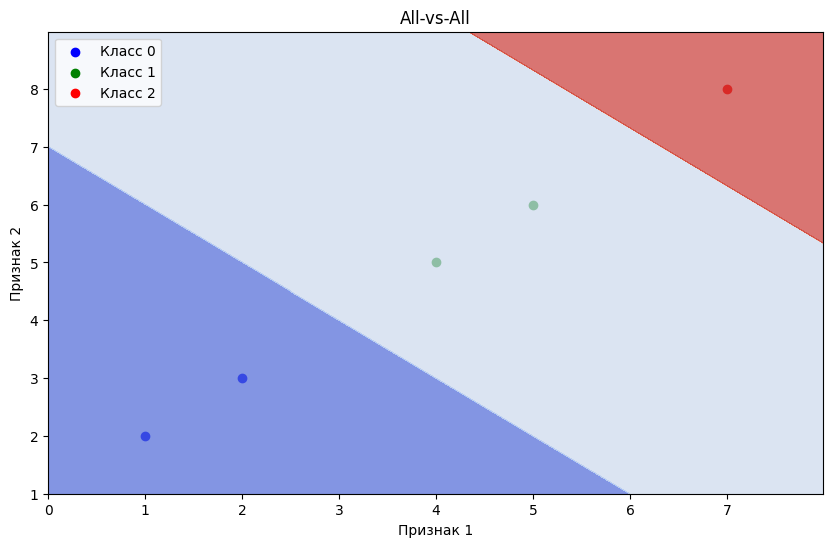

In [65]:
plot_ava_classifier(ava_classifier, X_test, y_test)